In [1]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy import stats
import umap

import anndata as ad
import scanpy as sc
import squidpy as sq
import seaborn as sns
import h5py
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm

# mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# # Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

2022-12-21 22:17:54.520221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Define the path where the files are located
DATA_PATH=('/mnt/ibm_lg/leah.dorman/Nanostring/Data/IBD_Michael_Kattah/')
data_files = os.listdir(os.path.join(DATA_PATH,'annotated_data'))
data_files
#'finalized_ndata_obj_12_13_2022.h5ad'

['.ipynb_checkpoints',
 'KNFC5VYF',
 '22_10_4_CosMx_umap_V5.h5ad',
 'finalized_ndata_obj_12_13_2022.h5ad']

In [3]:
#load in data file
datafile = data_files[3]
print(datafile)
ndata = sc.read_h5ad(os.path.join(DATA_PATH,'annotated_data',datafile))
ndata

finalized_ndata_obj_12_13_2022.h5ad


AnnData object with n_obs × n_vars = 48783 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'total_counts', 'total_counts_ercc', 'pct_counts_ercc', 'n_genes', 'n_counts', 'total_counts_mt', 'Endoscopic_severity', 'R_vs_L', 'leiden_v10_r1.6', 'Patient_samples', 'pct_counts_mt', 'leiden_v8_r1.6', 'fine_annotation', 'Coarse_annotation', 'leiden_v9_r0.4', 'Condition'
    var: 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'Coarse_annotation_colors', 'fine_annotation_colors', 'fov_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_global', 'X_umap', 'spatial', 'spatial_fov'
    varm: 'PCs'
    layers: 'log_normalized_counts', 'raw_counts'
    ob

In [4]:
#Export total counts to a csv file
#ndata.var.total_counts.to_csv('/mnt/ibm_lg/leah.dorman/Nanostring/total_counts.csv')


In [5]:
#identify ERCC probes
negprobes = [i for i in ndata.var.index if i.startswith('Neg')]
ndata.X = ndata.layers['raw_counts']
print(len(negprobes))
ndata.var.total_counts[ndata.var.index.isin(negprobes)].mean()

19


1155.8947368421052

Text(0, 0.5, 'Number of genes')

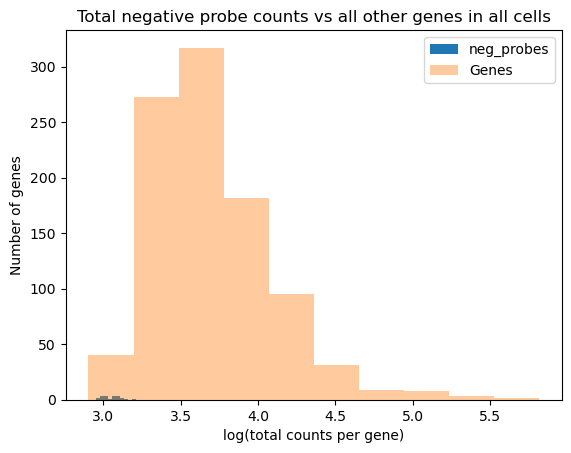

In [6]:
#add up the neg probes and all the other gene counts per cell
#plot scatter
array_neg = np.log10(ndata.var['total_counts'][ndata.var.index.isin(negprobes)])
array_pos = np.log10(ndata.var['total_counts'][~ndata.var.index.isin(negprobes)])


namedplot = 'cosmx'
fig1,namedplot=plt.subplots()
namedplot.hist(array_neg,alpha=1)
namedplot.hist(array_pos,alpha=0.4)
namedplot.legend(['neg_probes','Genes'],loc=1)

plt.xlabel('log(total counts per gene)')
plt.title('Total negative probe counts vs all other genes in all cells')
plt.ylabel('Number of genes')

In [7]:
#add in some plots like Yang-Joon's with individual genes
#define some relevant genes
marker_genes = {
    'CD4_T_Cell':['CD3D', 'CD40LG', 'IL7R'],
    'B_Cell':['CD52','CD37','MS4A1'],
    'mDendritic_Cell':['CLEC7A','CLEC10A'],
    'Endothelial':['KDR','RAMP3','VWF','PECAM1'],
    'Fibroblast':['MYH11','ACTA2','ACTG2'],
    'CD8_T_Cell':['KLRK1','CCL5'],
    'Crypt_TA_Cell':['SPINK1','AGR2','OLFM4'],
    'Macrophage':['C1QC','GPNMB','C1QB'],
    'Monocyte':['ITGAX','FGR','S100A8'],
    'Epithelial':['CEACAM6','KRT19','KRT20','CEACAM1','EPCAM','PIGR','KRT8'],
    'Treg':['CTLA4','FOXP3'],
    'NK_CD8_Cell':['GZMA','ITGAE','GZMH'],
    'Inflammatory_Macrophage':['MMP9','PTGDS','CCL18'],
    'Plasma_Cell':['IRF4','JCHAIN','MZB1'],
    'Mast_Cell':['TPSB2','TPSAB1','CPA3'],
    'ILC3':['KIT'], #,'RORC'
    'Enteric_Neurons':['CRYAB','S100B','NRXN1'], #'PLP1'
}

negprobes

['NegPrb3',
 'NegPrb5',
 'NegPrb6',
 'NegPrb7',
 'NegPrb8',
 'NegPrb9',
 'NegPrb10',
 'NegPrb11',
 'NegPrb12',
 'NegPrb13',
 'NegPrb14',
 'NegPrb15',
 'NegPrb16',
 'NegPrb18',
 'NegPrb19',
 'NegPrb20',
 'NegPrb21',
 'NegPrb22',
 'NegPrb23']

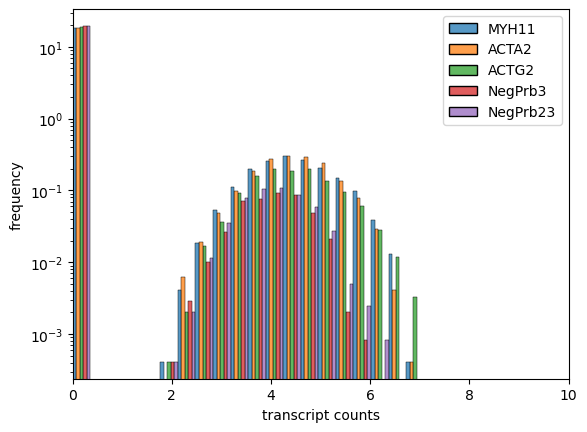

In [8]:
# Nanostring dataset
# set_plotting_style()
# plt.rc('figure', figsize=[8,6])

# convert to a dataframe for plotting
df_nanostring = pd.DataFrame(ndata.layers['log_normalized_counts'].toarray(),
                                       index = ndata.obs_names,
                                       columns = ndata.var_names)

list_markers = marker_genes['Fibroblast']+['NegPrb3','NegPrb23'] # neat1
#list_markers = markers_genes['Fibroblast']

ax = sns.histplot(df_nanostring.loc[:,list_markers], stat='percent', bins=20, multiple = 'dodge')

ax.set_xlabel('transcript counts')
ax.set_ylabel('frequency')
ax.set_xlim((0,10))
ax.set_yscale('log')
plt.show()

#scatter plot between neg probe and marker gene for each cell 

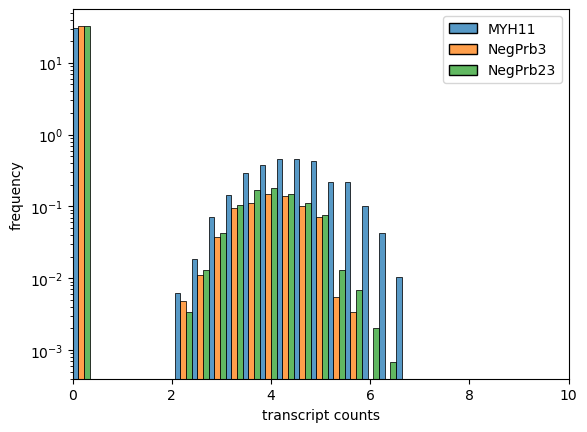

In [9]:
# Nanostring dataset
# set_plotting_style()
# plt.rc('figure', figsize=[8,6])

# convert to a dataframe for plotting
df_nanostring = pd.DataFrame(ndata.layers['log_normalized_counts'].toarray(),
                                       index = ndata.obs_names,
                                       columns = ndata.var_names)

list_markers = [marker_genes['Fibroblast'][0],'NegPrb3','NegPrb23'] # neat1
#list_markers = markers_genes['Fibroblast']

ax = sns.histplot(df_nanostring.loc[:,list_markers], stat='percent', bins=20, multiple = 'dodge')

ax.set_xlabel('transcript counts')
ax.set_ylabel('frequency')
ax.set_xlim((0,10))
ax.set_yscale('log')
plt.show()

#scatter plot between neg probe and marker gene for each cell 

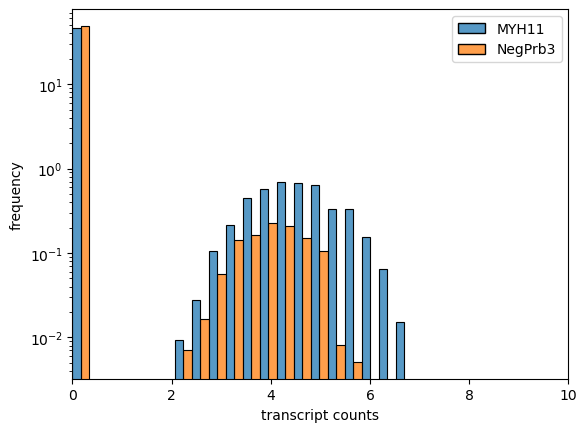

In [10]:
# Nanostring dataset
# set_plotting_style()
# plt.rc('figure', figsize=[8,6])

# convert to a dataframe for plotting
df_nanostring = pd.DataFrame(ndata.layers['log_normalized_counts'].toarray(),
                                       index = ndata.obs_names,
                                       columns = ndata.var_names)

list_markers = [marker_genes['Fibroblast'][0],'NegPrb3'] # neat1
#list_markers = markers_genes['Fibroblast']

ax = sns.histplot(df_nanostring.loc[:,list_markers], stat='percent', bins=20, multiple = 'dodge')

ax.set_xlabel('transcript counts')
ax.set_ylabel('frequency')
ax.set_xlim((0,10))
ax.set_yscale('log')
plt.show()

#scatter plot between neg probe and marker gene for each cell 

In [11]:
myh11_counts = ndata.layers['raw_counts'][:,ndata.var_names =='MYH11']
x = ndata[myh11_counts>0]
negprobe3counts = x.layers['raw_counts'][:,x.var_names == 'NegPrb3']
y = x[negprobe3counts > 0]
y

View of AnnData object with n_obs × n_vars = 113 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'total_counts', 'total_counts_ercc', 'pct_counts_ercc', 'n_genes', 'n_counts', 'total_counts_mt', 'Endoscopic_severity', 'R_vs_L', 'leiden_v10_r1.6', 'Patient_samples', 'pct_counts_mt', 'leiden_v8_r1.6', 'fine_annotation', 'Coarse_annotation', 'leiden_v9_r0.4', 'Condition'
    var: 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'Coarse_annotation_colors', 'fine_annotation_colors', 'fov_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_global', 'X_umap', 'spatial', 'spatial_fov'
    varm: 'PCs'
    layers: 'log_normalized_counts', 'raw_counts'


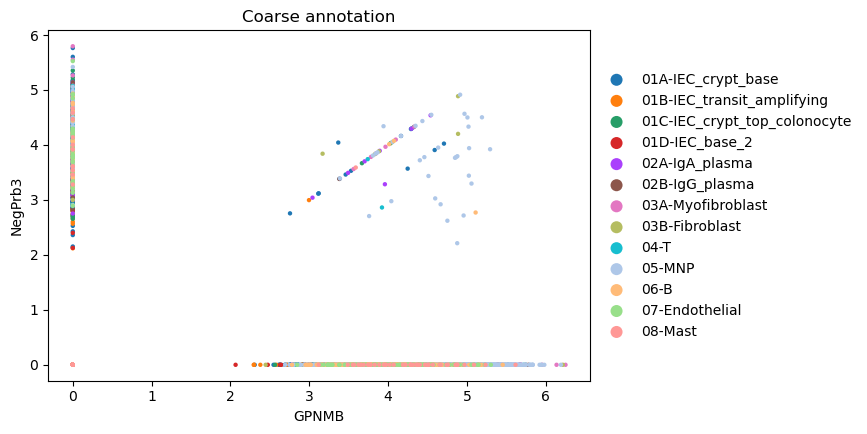

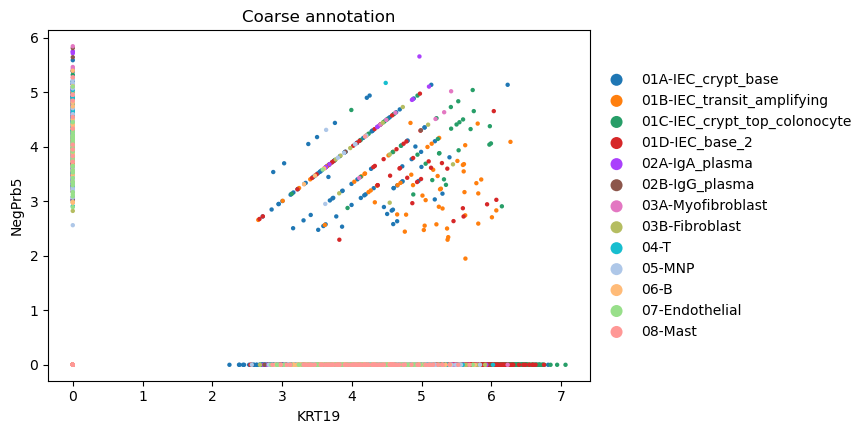

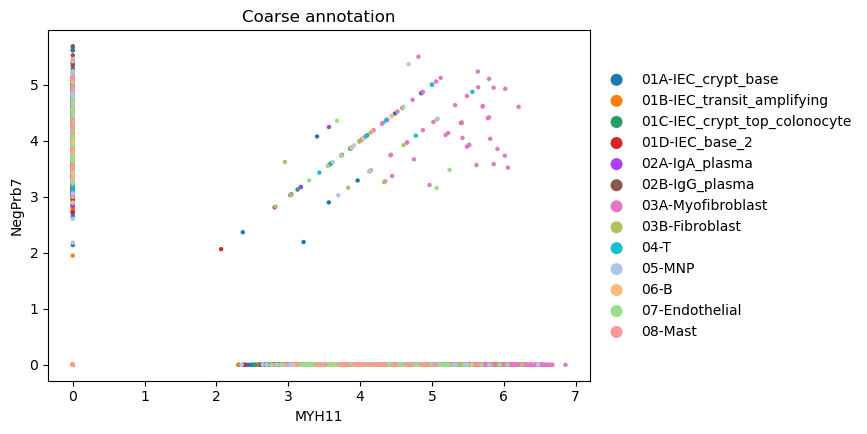

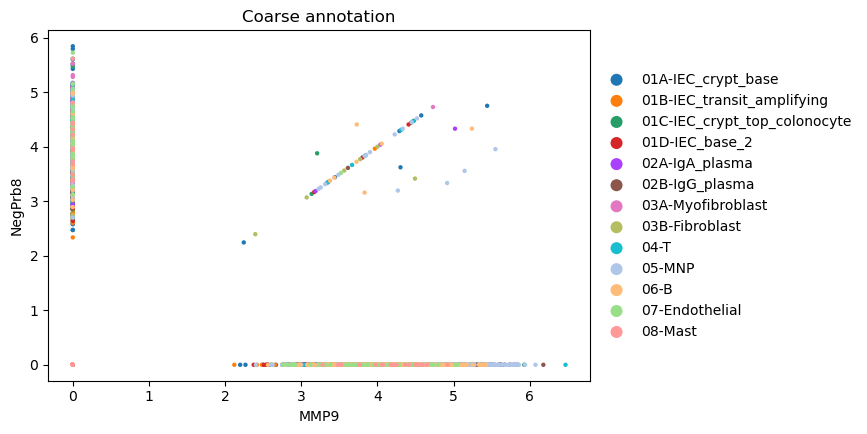

In [12]:
#scatter plot between neg probe and marker gene for each cell 

sc.pl.scatter(ndata,x='GPNMB',y='NegPrb3',color = 'Coarse_annotation',use_raw=False,layers='log_normalized_counts',size = 40)
sc.pl.scatter(ndata,x='KRT19',y='NegPrb5',color = 'Coarse_annotation',use_raw=False,layers='log_normalized_counts',size = 40)
sc.pl.scatter(ndata,x='MYH11',y='NegPrb7',color = 'Coarse_annotation',use_raw=False,layers='log_normalized_counts',size = 40)
sc.pl.scatter(ndata,x='MMP9',y='NegPrb8',color = 'Coarse_annotation',use_raw=False,layers='log_normalized_counts',size = 40)

#scatter plot between neg probe and marker gene for each cell 

In [13]:
#make a giant marker gene that's just negative counts for each cell
negprobes
cellcount_negprobes = ndata.layers['raw_counts'][:,ndata.var_names.isin(negprobes)].toarray().sum(axis=1)
len(cellcount_negprobes[cellcount_negprobes == 0])
ndata_small = ndata[cellcount_negprobes==0]

ndata_withnegprobes = ndata[cellcount_negprobes > 0]
#might be worth subsetting to only cells with 0 negative probe counts (34818)

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


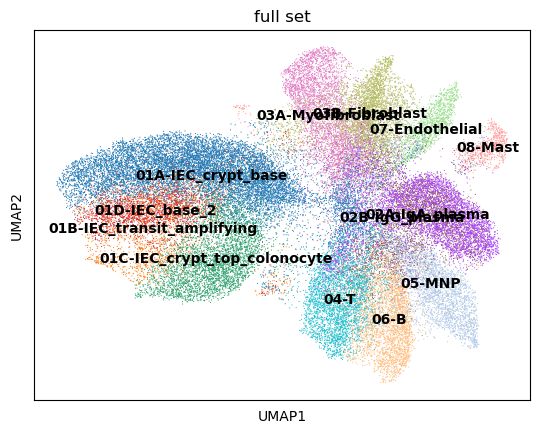

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


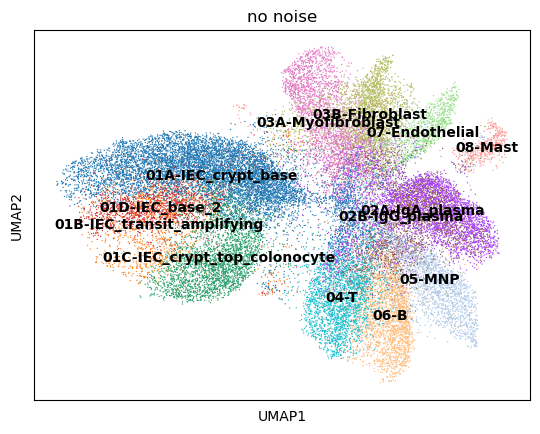

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


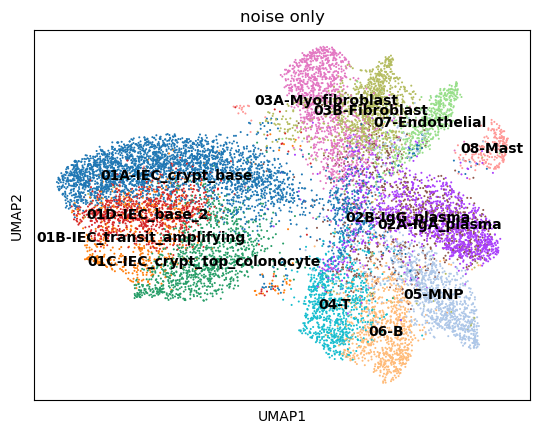

In [14]:
sc.pl.umap(ndata,color = 'Coarse_annotation',legend_loc='on data',title='full set')
sc.pl.umap(ndata_small,color = 'Coarse_annotation',legend_loc='on data',title='no noise')
sc.pl.umap(ndata_withnegprobes,color = 'Coarse_annotation',legend_loc='on data',title = 'noise only')

In [15]:
#spatial distribution of noisy cells? 

#spatial plots of differentially expressed genes

#done #subset to only genes that are substantially higher than the negative probes
#IL1B - not present at all

#look at the spatial correlation between different cell types within ~50 um or so instead of over the full fov (maybe surrounding each crypt)
#(activated macrophages vs activated fibroblasts)
#overlay between control and UC, average over each fov



/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


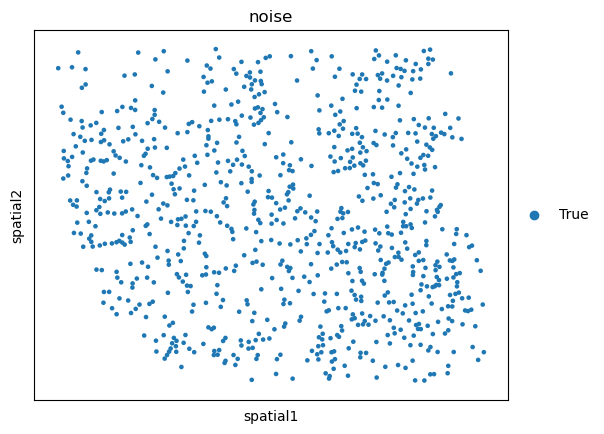

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


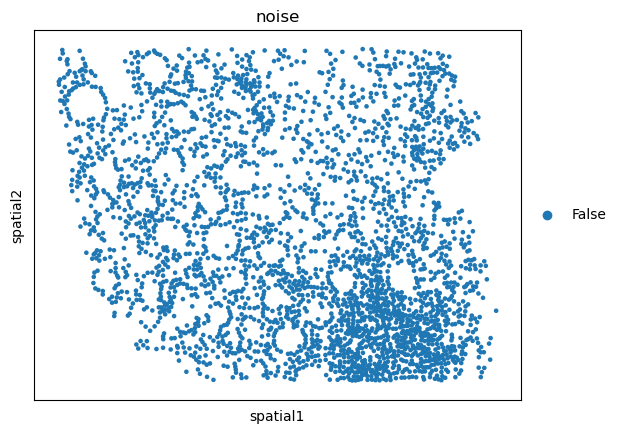

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categori

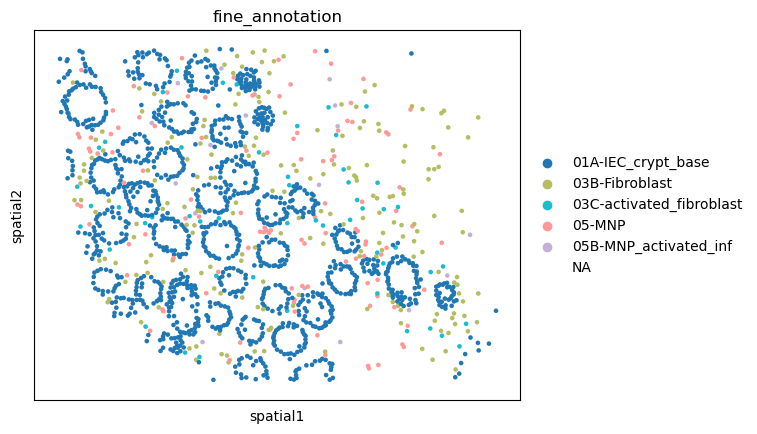

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


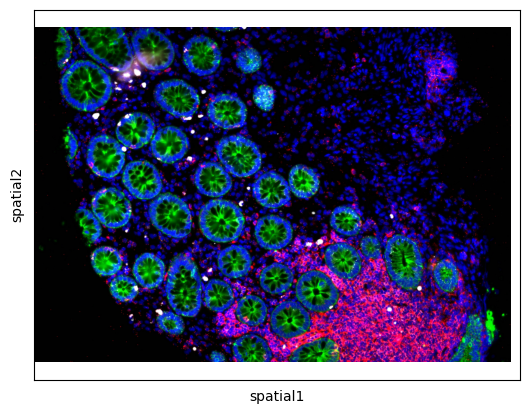

In [16]:
#print some spatial plots of the noisy cells
cell_barcodes_noise = ndata_withnegprobes.obs.index
cell_barcodes_nonoise = ndata_small.obs.index

#a if C else b for i in items
ndata.obs['noise']=['True' if i in cell_barcodes_noise else 'False' for i in ndata.obs.index]

# Check if the raw staining images are also loaded - This needs to be explored further to see what we'd like to visualize)
sc.pl.spatial(ndata[(ndata.obs.fov=='1') & (ndata.obs.noise=='True')], color=['noise'],
              alpha_img=0, library_id="1", spot_size=50) # 1st field of view

sc.pl.spatial(ndata[(ndata.obs.fov=='1') & (ndata.obs.noise=='False')], color=['noise'],
              alpha_img=0, library_id="1", spot_size=50) # 1st field of view

sc.pl.spatial(ndata[ndata.obs.fov=='1'], color=['fine_annotation'],groups = ['03B-Fibroblast','01A-IEC_crypt_base','05-MNP','03C-activated_fibroblast','05B-MNP_activated_inf'],
              alpha_img=0, library_id="1", spot_size=50) # 1st field of view

sc.pl.spatial(ndata[(ndata.obs.fov=='1')], 
              alpha_img=1, library_id="1", spot_size=50) # 1st field of view

In [17]:
#filter genes that are below ercc thresholds? 
#filter cells with high or low noise? 



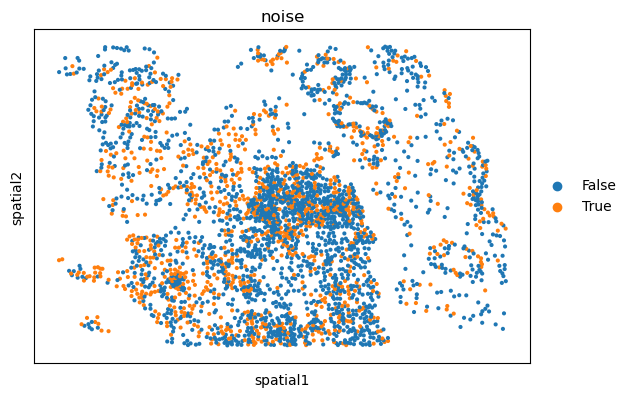

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categori

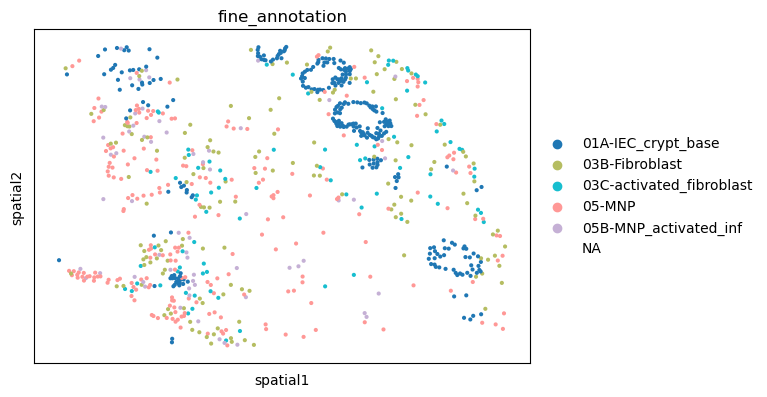

In [18]:
sc.pl.spatial(ndata[ndata.obs.fov=='3'], color=['noise'],
              alpha_img=0, library_id="3", spot_size=50) # 1st field of view

sc.pl.spatial(ndata[ndata.obs.fov=='3'], color=['fine_annotation'],groups = ['03B-Fibroblast','01A-IEC_crypt_base','05-MNP','03C-activated_fibroblast','05B-MNP_activated_inf'],
              alpha_img=0, library_id="3", spot_size=50) # 1st field of view

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


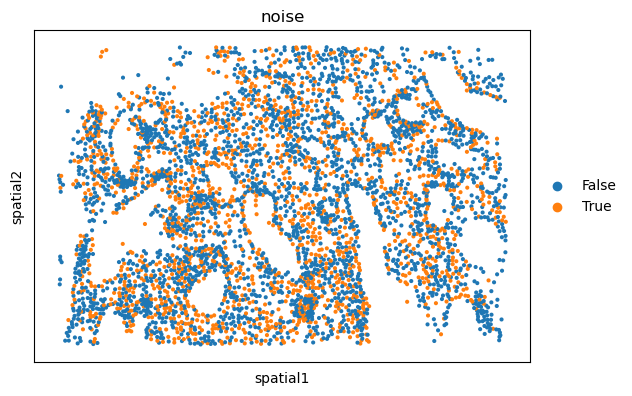

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


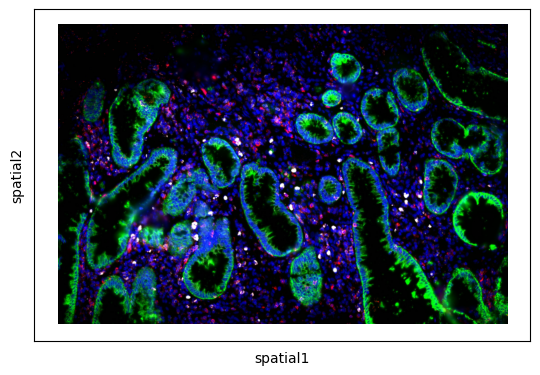

In [19]:
sc.pl.spatial(ndata[ndata.obs.fov=='4'], color=['noise'],
              alpha_img=0, library_id="4", spot_size=50) # 1st field of view

sc.pl.spatial(ndata[ndata.obs.fov=='4'],
              alpha_img=1, library_id="4", spot_size=50) # 1st field of view



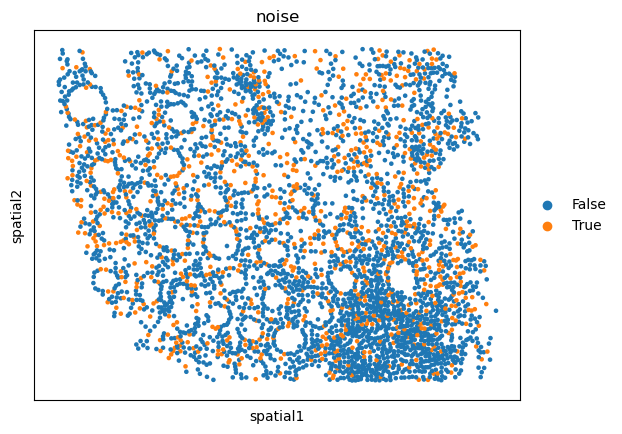

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


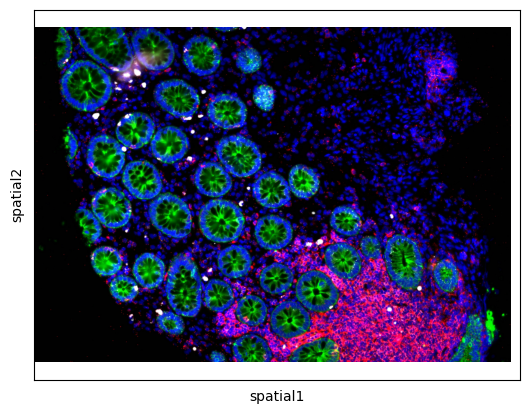

In [20]:
sc.pl.spatial(ndata[ndata.obs.fov=='1'], color=['noise'],
              alpha_img=0, library_id="1", spot_size=50,use_raw = False) # 1st field of view

sc.pl.spatial(ndata[ndata.obs.fov=='1'],
              alpha_img=1, library_id="1", spot_size=50,use_raw = False) # 1st field of vie

In [21]:
#note: we decided NOT to do this
#1: Subset genes to those that are substantially (2x) higher in the total dataset than the negative probes
#min = 10**array_neg.max()
#print(min)
#keep_genes = array_pos[10**array_pos > min*2].index
#keep_genes

#subset ndata
#ndata = ndata[:,ndata.var.index.isin(keep_genes)].copy()
#ndata = ndata[~ndata.obs.Condition.isna()].copy()

#print(ndata)
#write to an h5ad
#ndata.write_h5ad('/mnt/ibm_lg/leah.dorman/Nanostring/Data/IBD_Michael_Kattah/processed_data/nanostring_IBD_normalized_umap_subset_2xERCC_12522.h5ad')

  

In [22]:
all_fov = sorted(set(ndata.obs.fov))
annotation_col = 'fine_annotation'
celltype_1 = '05B-MNP_activated_inf'
celltypes_to_compare = ['01A-IEC_crypt_base','03B-Fibroblast','05-MNP','03C-activated_fibroblast','05B-MNP_activated_inf',]
data_frame_total = pd.DataFrame()

VDZ_fov_1_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0
UC_fov_11_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0
UC_fov_13_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


0.0 100.0
HC_fov_14_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0
HC_fov_15_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0
HC_fov_16_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0
HC_fov_17_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0
HC_fov_18_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


0.0 100.0
HC_fov_19_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


0.0 100.0
VDZ_fov_2_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0
HC_fov_20_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/squidpy/pl/_utils.py:545: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(constrained_layout=True, dpi=dpi, figsize=figsize)


0.0 100.0
HC_fov_21_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


0.0 100.0
VDZ_fov_3_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0
VDZ_fov_4_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0
UC_fov_5_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


0.0 100.0
UC_fov_6_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0
VDZ_fov_9_vs_05B-MNP_activated_inf


  0%|          | 0/1000 [00:00<?, ?/s]

0.0 100.0


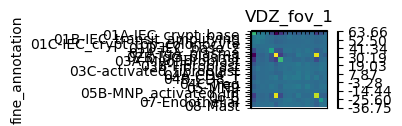

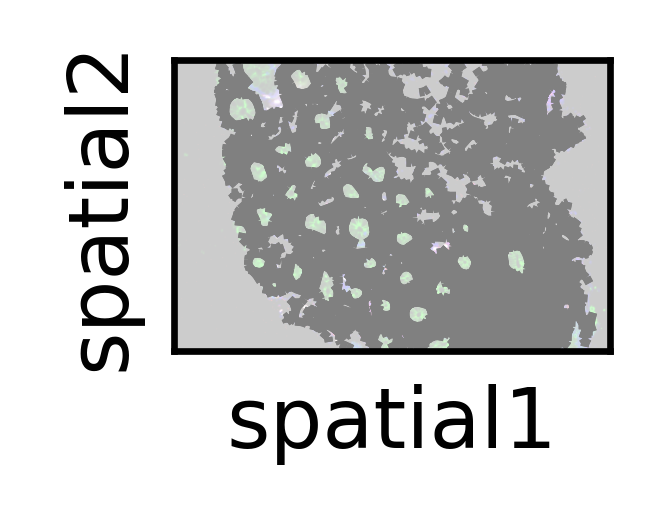

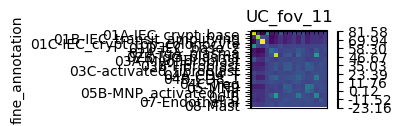

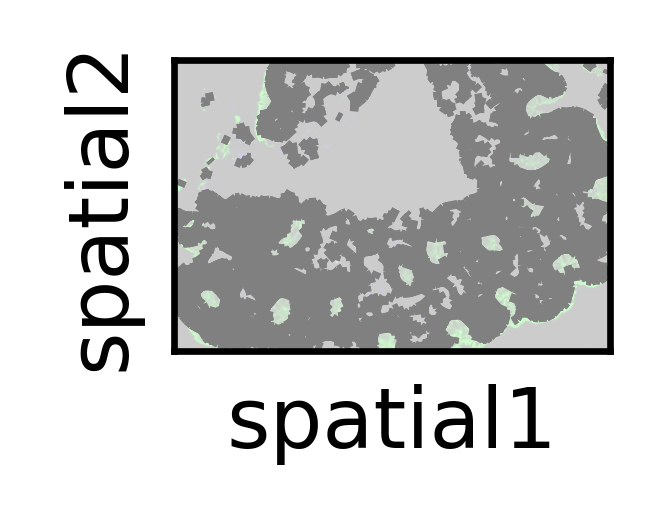

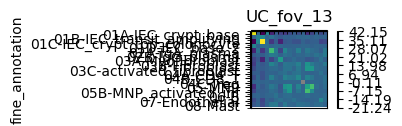

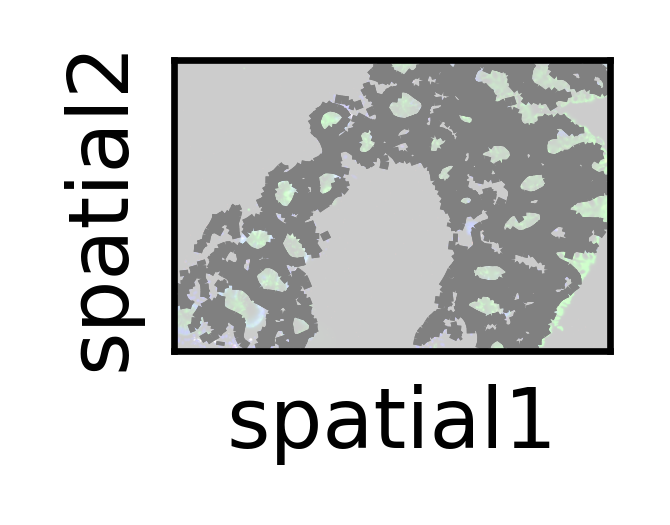

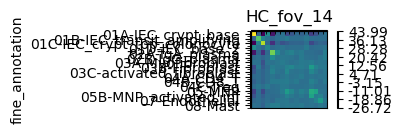

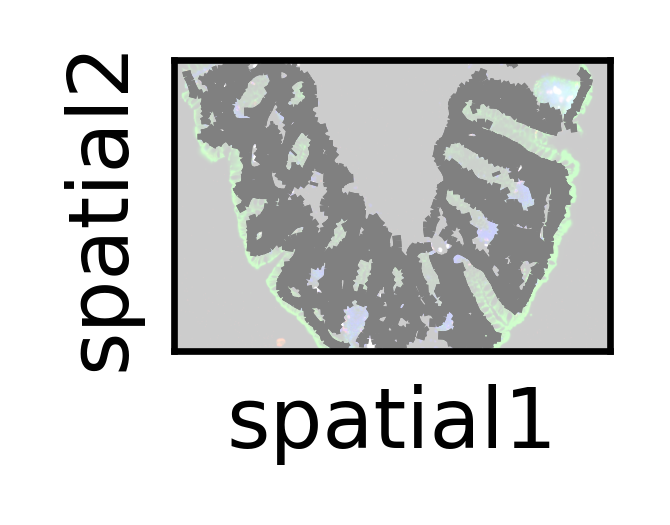

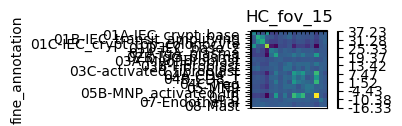

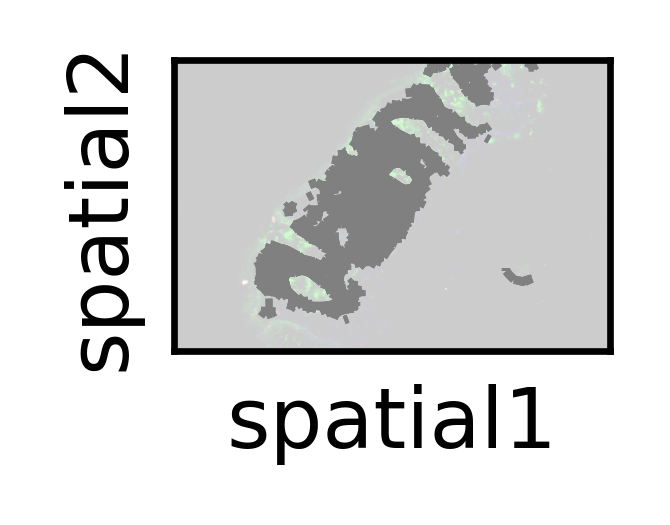

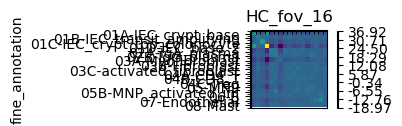

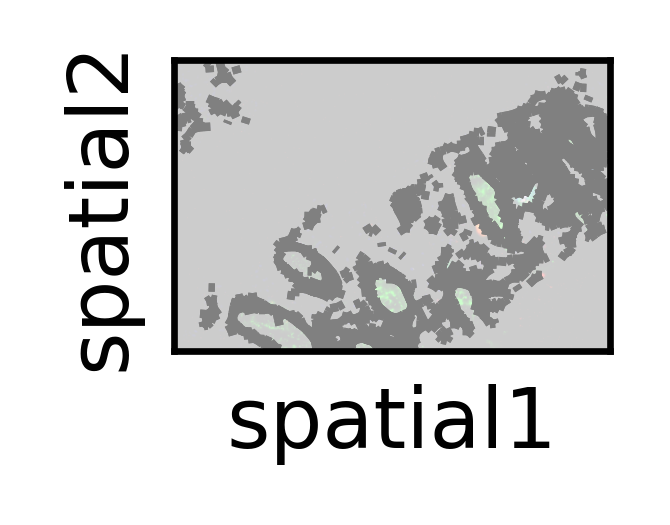

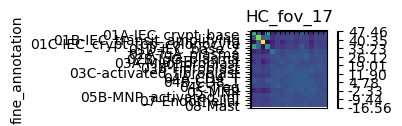

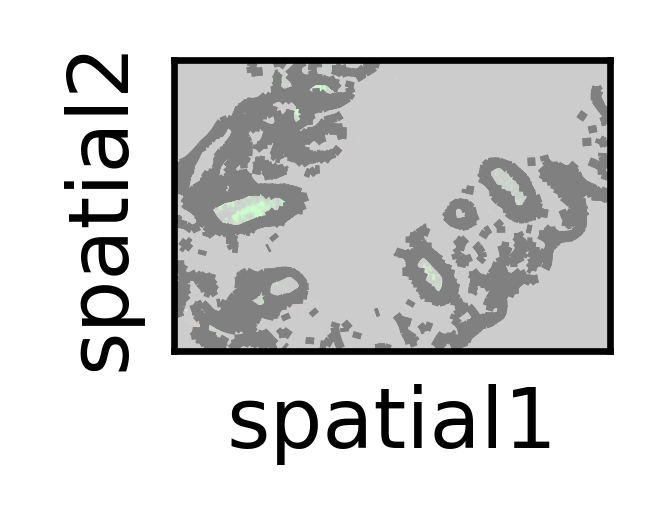

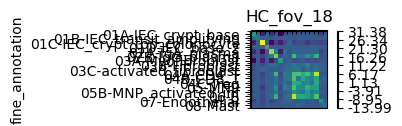

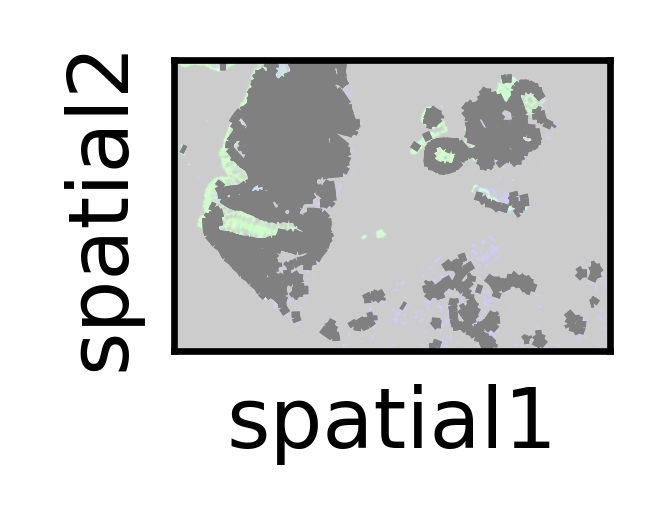

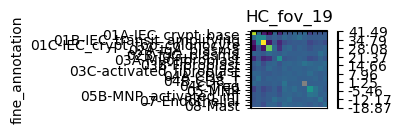

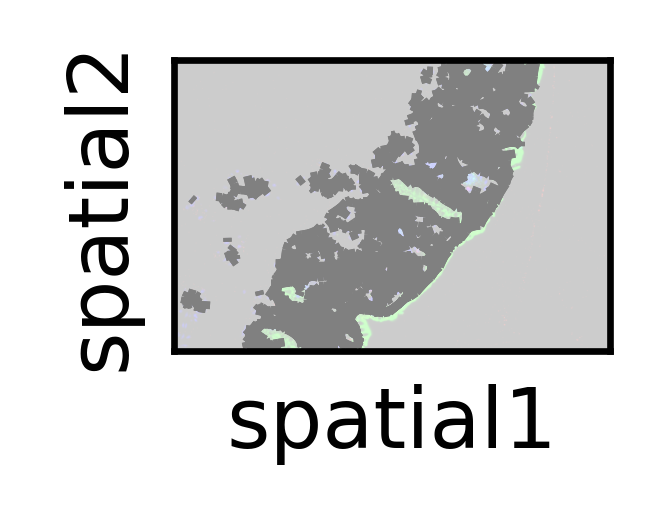

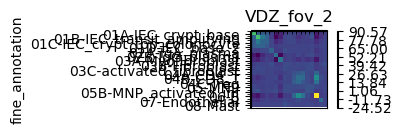

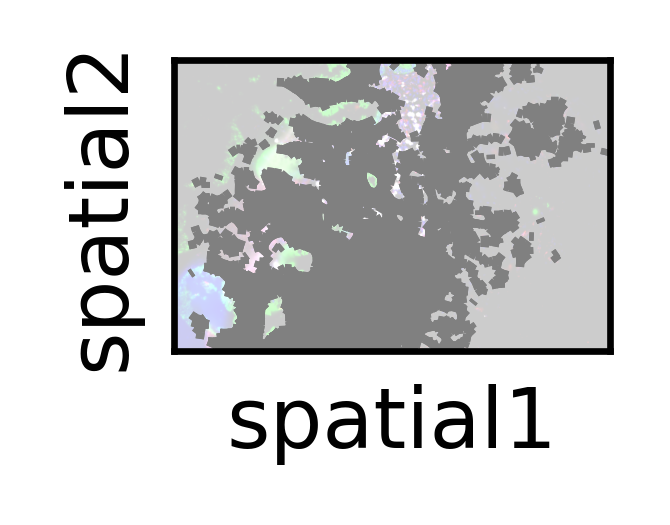

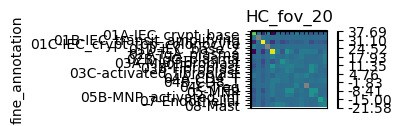

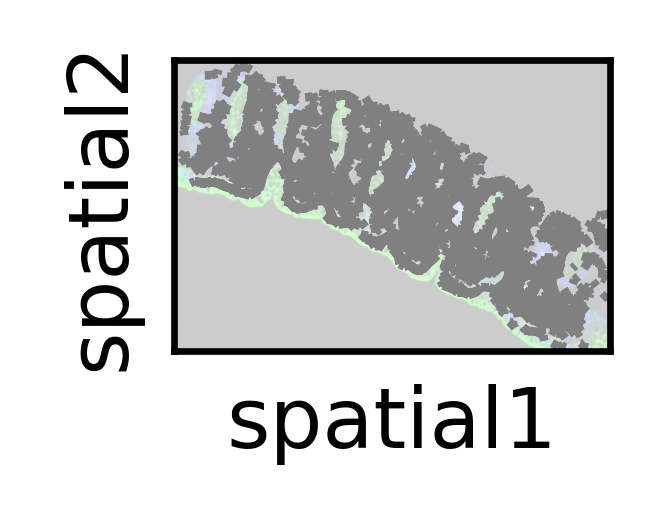

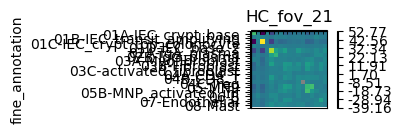

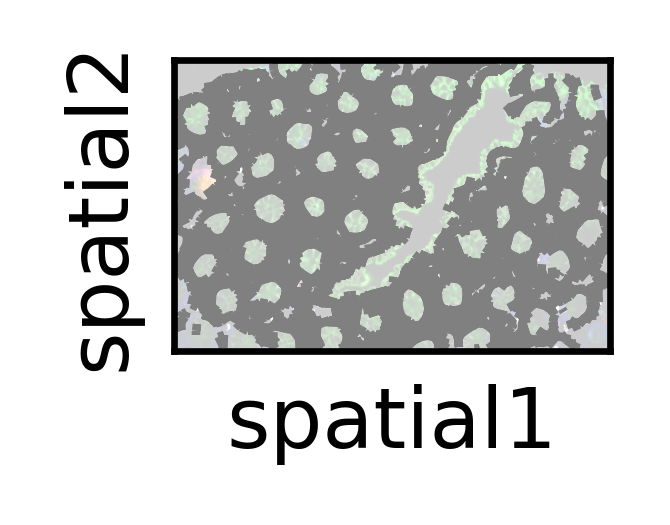

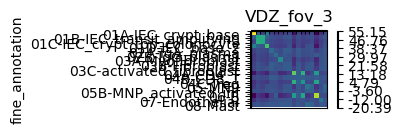

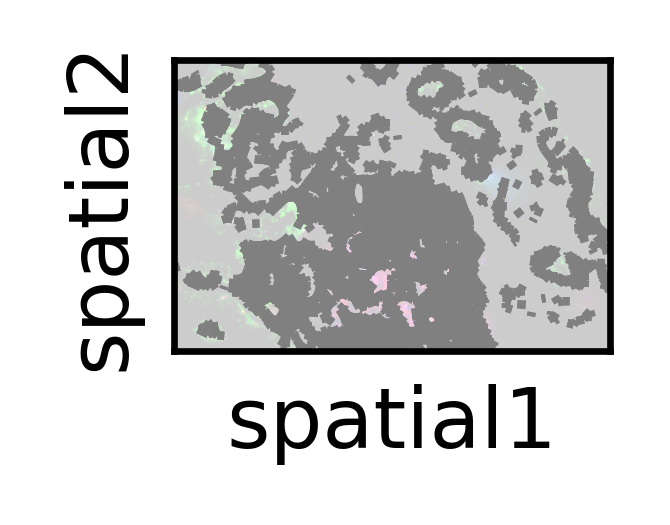

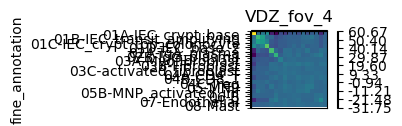

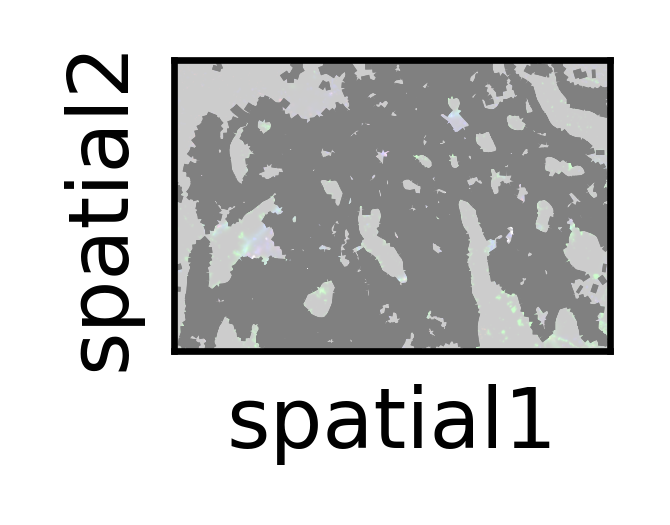

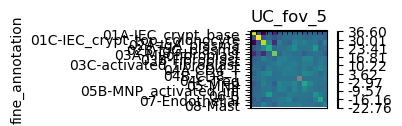

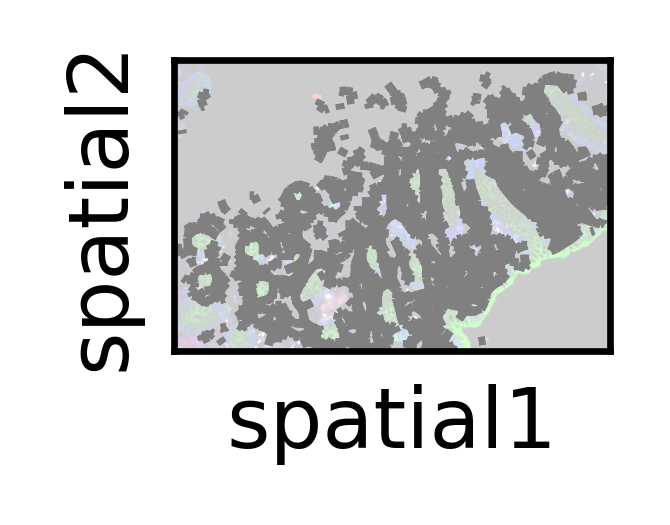

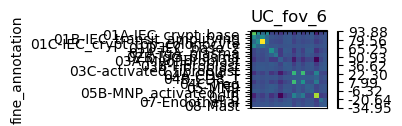

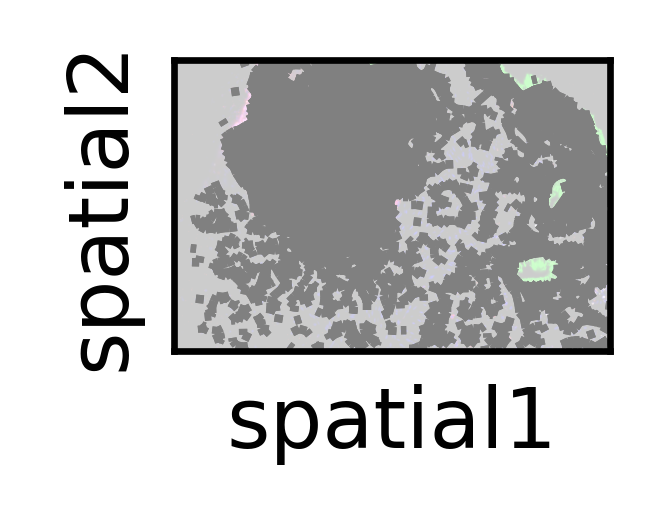

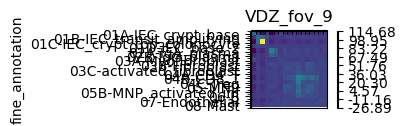

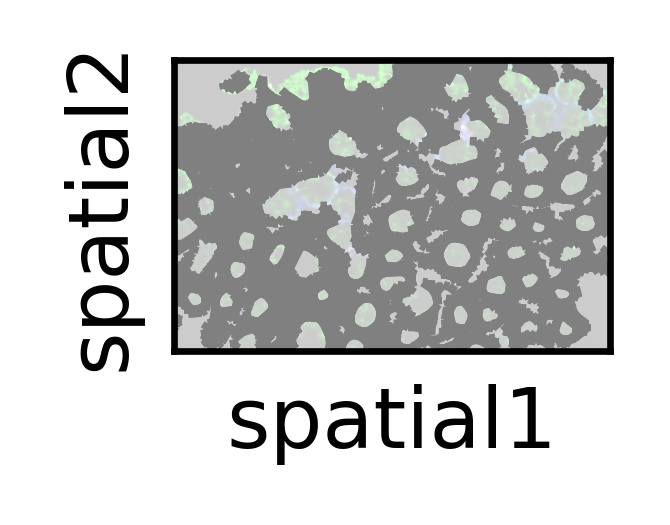

In [36]:
for region in all_fov:
    #split the object by fov
    adata = ndata[ndata.obs.fov==region].copy()
    
    #find the condition
    condition = list(set(adata.obs.Condition))[0]
    
    #build a column name
    col_name = condition+'_fov_'+region+'_vs_'+celltype_1
    print(col_name)
    
    #calculate neighborhood graph
    sq.gr.spatial_neighbors(adata,coord_type = 'generic',radius = 100)
    sq.gr.nhood_enrichment(adata, cluster_key=annotation_col)
    sq.pl.nhood_enrichment(adata, 
                           cluster_key=annotation_col,
                           title = condition+'_fov_'+region,
                           figsize=[2,2],
                           show=False,
                           save ='/mnt/ibm_lg/leah.dorman/Nanostring/figures/spatial_neighbors/'+condition + region+'heatmap.pdf')
    nbhd_enrichment = adata.uns[annotation_col+'_nhood_enrichment']['zscore']
    print(adata.obsp['spatial_distances'].min(),adata.obsp['spatial_distances'].max())
    sq.pl.spatial_scatter(adata, 
                          connectivity_key="spatial_connectivities", 
                          img=True, 
                          img_alpha=0.2,
                          na_color="lightgrey",
                          library_id = region,
                          #scalebar_units = 'um',
                          #scalebar_dx=0.16,
                          #scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
                          figsize = (1,1),
                          dpi = 600,
                          save = '/mnt/ibm_lg/leah.dorman/Nanostring/figures/spatial_neighbors/'+condition+region+'image.pdf')

    #build a data frame
    df = pd.DataFrame(nbhd_enrichment)
    df.columns = sorted(set(adata.obs[annotation_col]))
    df.index = sorted(set(adata.obs[annotation_col]))
    
    #pull out celltypes of interest
    df = df.loc[celltypes_to_compare,celltype_1]
    
    #add to data_frame_total
    data_frame_total[col_name] = df
    

    #note: when the scale bar is at 1x, then it thinks the size is 5.5 * 1 mm = 5.5 mm = 5500 um. In actuality, the size is 900 um wide
    
    #maybe I need to multiply everything by 6.25? 50*6.25 = 312.5

In [25]:
data_frame_total = data_frame_total.sort_index(axis=1)
data_frame_total.to_csv('/mnt/ibm_lg/leah.dorman/Nanostring/Data/fine_neighborhood_enrichment_vs_activatedMNP_100_radius_121422.csv')
!rclone copy /mnt/ibm_lg/leah.dorman/Nanostring/Data/fine_neighborhood_enrichment_vs_activatedMNP_100_radius_121422.csv gdrive:Nanostring/Spreadsheets/

In [26]:
data_frame_total = data_frame_total.sort_index(axis=1)
data_frame_total

HC_fov_14_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                 -8.238446   
03B-Fibroblast                                      4.428766   
05-MNP                                             14.209503   
03C-activated_fibroblast                            1.989735   
05B-MNP_activated_inf                               2.861675   

                          HC_fov_15_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                 -2.107761   
03B-Fibroblast                                     -0.197903   
05-MNP                                              4.230633   
03C-activated_fibroblast                           -1.303429   
05B-MNP_activated_inf                               2.661012   

                          HC_fov_16_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                 -2.234995   
03B-Fibroblast                                     -0.595166   
05-MNP                                              1.849078   
03C-activated_fibroblast                           -0.966971   
05B-MNP_activated_inf                               1.864860   

                          HC_fov_17_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                 -3.341828   
03B-Fibroblast                                     -0.067552   
05-MNP                                              0.897764   
03C-activated_fibroblast                           -0.389042   
05B-MNP_activated_inf                              -0.569652   

                          HC_fov_18_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                 -1.802749   
03B-Fibroblast                                     -0.112992   
05-MNP                                             11.816821   
03C-activated_fibroblast                            1.355108   
05B-MNP_activated_inf                               4.257809   

                          HC_fov_19_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                 -2.746770   
03B-Fibroblast                                      0.614426   
05-MNP                                              4.274385   
03C-activated_fibroblast                            1.083831   
05B-MNP_activated_inf                               3.688736   

                          HC_fov_20_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                 -3.679521   
03B-Fibroblast                                      3.448308   
05-MNP                                              8.419872   
03C-activated_fibroblast                            2.352703   
05B-MNP_activated_inf                               2.494460   

                          HC_fov_21_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                 -6.879193   
03B-Fibroblast                                      8.522382   
05-MNP                                             25.267619   
03C-activated_fibroblast                            3.592214   
05B-MNP_activated_inf                               9.769899   

                          UC_fov_11_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                 -8.338689   
03B-Fibroblast                                      3.899727   
05-MNP                                             15.242115   
03C-activated_fibroblast                            6.676670   
05B-MNP_activated_inf                               7.246882   

                          UC_fov_13_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                 -7.746267   
03B-Fibroblast                                      4.898172   
05-MNP                                             23.768678   
03C-activated_fibroblast                           12.911790   
05B-MNP_activated_inf                               9.946720   

                          UC_fov_5_vs_05B-MNP_activated_inf  \
01A-IEC_crypt_base                                -2.941915   
03B-Fibroblast                                    

Field of view:  11 Condition:  UC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  5 Condition:  UC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  13 Condition:  UC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  6 Condition:  UC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  18 Condition:  HC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  15 Condition:  HC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  21 Condition:  HC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  17 Condition:  HC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  16 Condition:  HC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  20 Condition:  HC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  19 Condition:  HC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  14 Condition:  HC


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  2 Condition:  VDZ


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  4 Condition:  VDZ


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  1 Condition:  VDZ


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  9 Condition:  VDZ


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.
Field of view:  3 Condition:  VDZ


  0%|          | 0/1 [00:00<?, ?/s]

Co-occurrence probabilities computed.


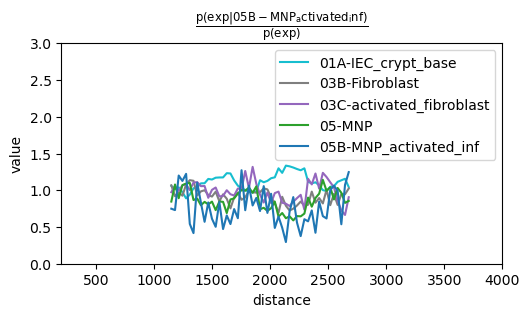

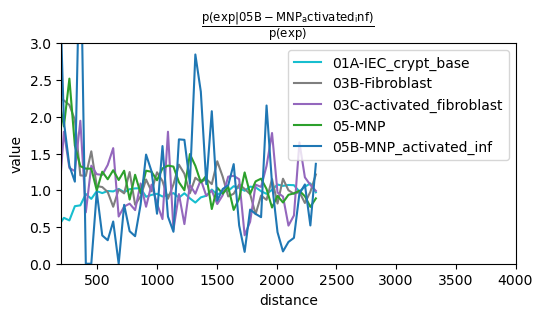

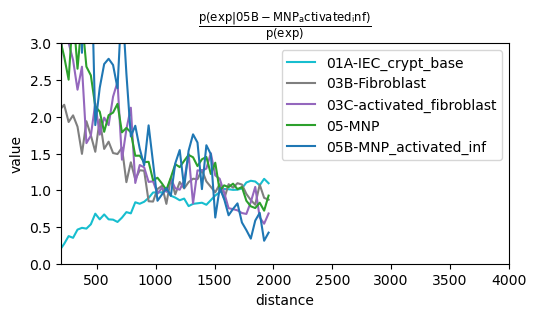

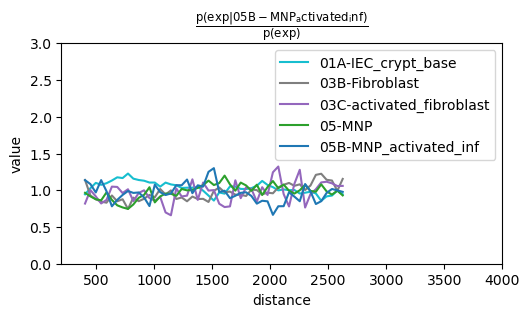

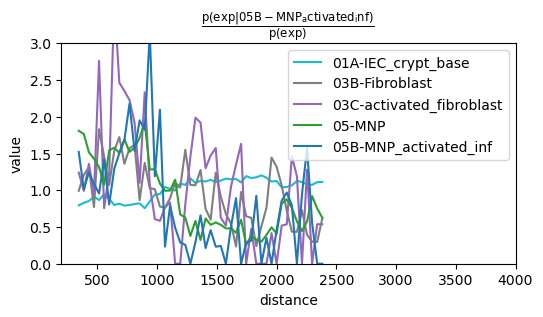

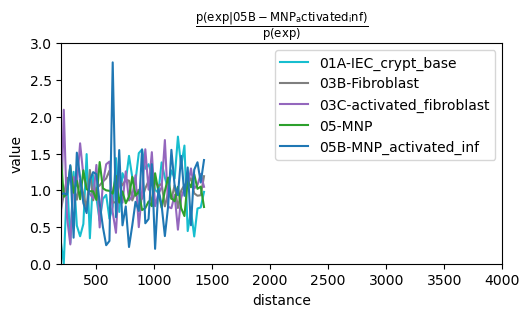

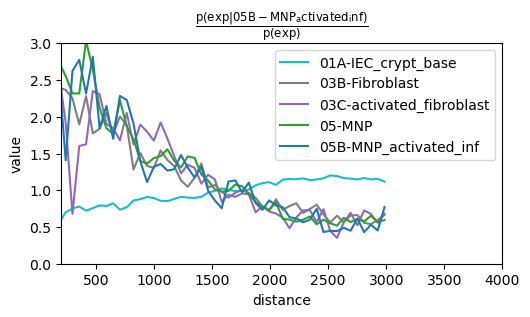

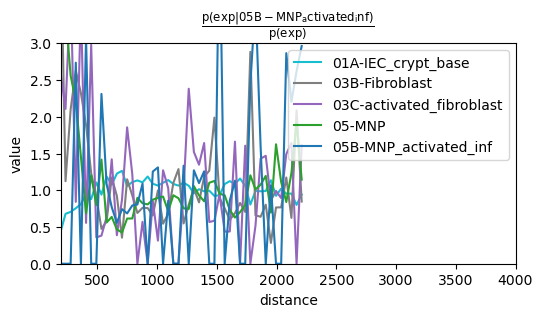

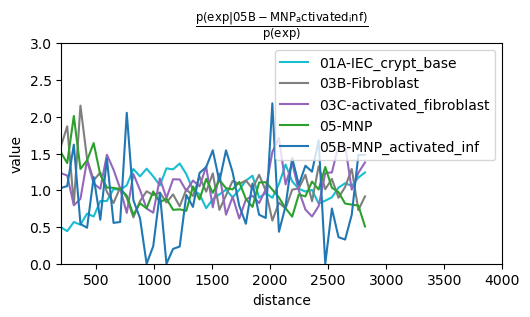

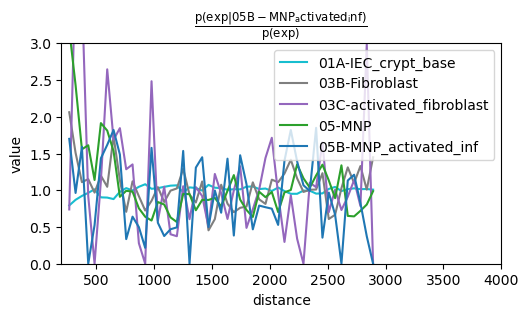

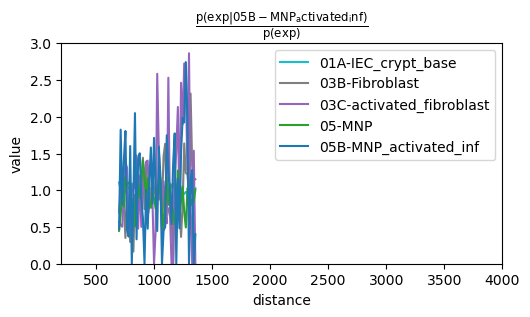

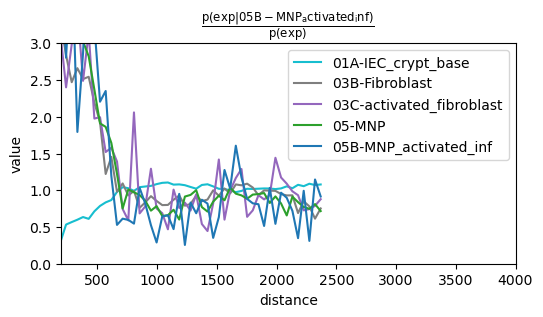

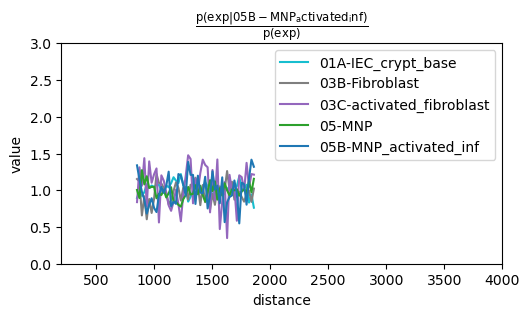

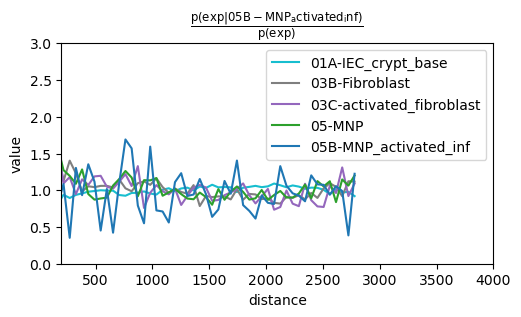

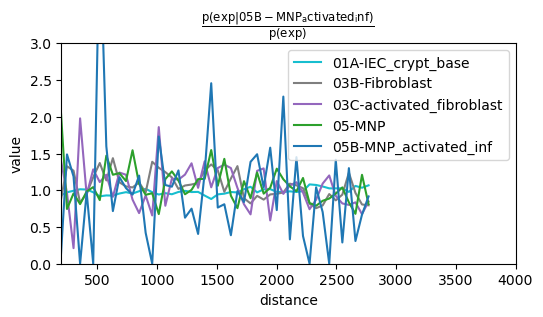

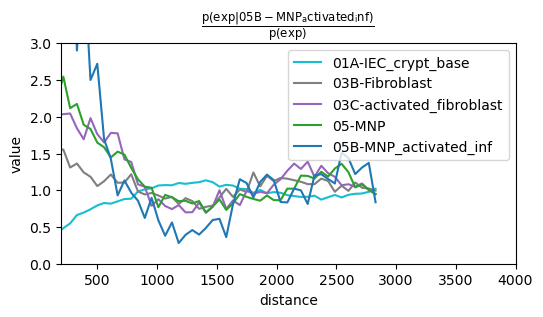

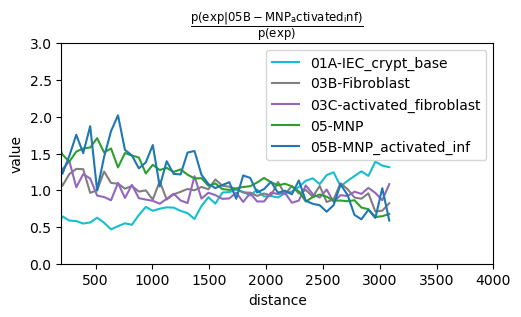

In [27]:
#coocurrence probability graph? from jonathan
# Get just the activated macrophage and fibroblasts
clusters = ['03C-activated_fibroblast','05B-MNP_activated_inf','01A-IEC_crypt_base','03B-Fibroblast','05-MNP']
subset = ndata[ndata.obs['fine_annotation'].isin(clusters)].copy()

#get each fov individually
for condition in set(ndata.obs.Condition):
    set_of_fov = set(ndata.obs.fov[ndata.obs.Condition==condition])
    for fov in set_of_fov:
    
        temp = subset[subset.obs.fov==fov].copy()
        print("Field of view: ",fov, "Condition: ",temp.obs.Condition[0])
    # Calculate squidpy co-occurrence
#intervals = np.arange(20,500,20)
        sq.gr.co_occurrence(temp, 
                    cluster_key='fine_annotation',
                    n_splits=0,
                    n_jobs=100)

        print('Co-occurrence probabilities computed.')
        #print(temp.uns['fine_annotation_co_occurrence']['occ'][0][0])
        if pd.isna((temp.uns['fine_annotation_co_occurrence']['occ'][0][0][0])):
            print("no co-occurrence could be calculated")
            continue
# Plot co-occurrence
        sq.pl.co_occurrence(temp, cluster_key="fine_annotation", 
                            clusters = '05B-MNP_activated_inf', 
                            figsize=(5,3),
                            palette='tab10_r',
                            legend_kwargs={'loc':'best'},
                            save = '/mnt/ibm_lg/leah.dorman/Nanostring/figures/co_ocurrence/'+condition+fov+'.pdf')
        plt.xlim(200,4000)
        plt.ylim(0,3)
        #plt.show()

        

In [28]:
#show an average for each condition for macrophage vs fibroblast (0, 1)
print(clusters)
#for cluster a, print array for cluster

cc = temp.uns['fine_annotation_co_occurrence']['occ'][0,1,:]
dist = temp.uns['fine_annotation_co_occurrence']['interval'][1:]



['03C-activated_fibroblast', '05B-MNP_activated_inf', '01A-IEC_crypt_base', '03B-Fibroblast', '05-MNP']


In [29]:
temp.uns['fine_annotation_co_occurrence']



{'occ': array([[[1.597412  , 1.5687692 , 1.5708369 , ..., 0.73802197,
          0.71798974, 0.72668046],
         [0.49768996, 0.5878669 , 0.5745372 , ..., 1.1226184 ,
          1.1574157 , 1.1317376 ],
         [0.54754215, 0.63035136, 0.5771365 , ..., 1.0095779 ,
          1.0453278 , 1.0194397 ],
         [0.2779184 , 0.40289786, 0.41895142, ..., 1.2565746 ,
          1.257782  , 1.2772957 ],
         [0.43655783, 0.6457258 , 0.5872719 , ..., 1.3898292 ,
          1.3356837 , 1.3144833 ]],
 
        [[0.49768996, 0.58786684, 0.5745372 , ..., 1.1226186 ,
          1.1574157 , 1.1317378 ],
         [1.6083565 , 1.3119957 , 1.6419754 , ..., 0.9076825 ,
          0.9355048 , 0.9944166 ],
         [1.2368795 , 1.5967011 , 1.2505308 , ..., 0.93326265,
          0.94962066, 0.8809112 ],
         [1.5821478 , 1.3600256 , 1.2541816 , ..., 0.9607116 ,
          0.87777936, 0.87169474],
         [1.3254552 , 1.060058  , 1.2192514 , ..., 0.71175164,
          0.7224956 , 0.82339454]],
 
       

# Save the figure
fig.savefig('../../figures/SIFig_liver_cooccurrence.svg', transparent=True)
fig.savefig('../../figures/SIFig_liver_cooccurrence.png', transparent=True)

print('Figures saved.')

Figure outline
1. 1 field of view with image picture
B: QC with ERCC, counts, genes, thresholds
C. UMAP plot with annotations (incl. un-annotated cells)
D. labelled spatial plot with image + cell types, then zoom in on one crypt, label ~3 cell types only
E. co-ocurrence graph (jonathan) > pick radius
F: neighborhood enrichment graph with the above radius, then quantification with prism

In [30]:
print(adata.obsm['X_spatial'].min(),adata.obsm['X_spatial'].max())

-177380.444444444 34458.5555555556


In [31]:
adata

AnnData object with n_obs × n_vars = 3939 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD45', 'Max.CD45', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'total_counts', 'total_counts_ercc', 'pct_counts_ercc', 'n_genes', 'n_counts', 'total_counts_mt', 'Endoscopic_severity', 'R_vs_L', 'leiden_v10_r1.6', 'Patient_samples', 'pct_counts_mt', 'leiden_v8_r1.6', 'fine_annotation', 'Coarse_annotation', 'leiden_v9_r0.4', 'Condition', 'noise'
    var: 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'Coarse_annotation_colors', 'fine_annotation_colors', 'fov_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap', 'spatial_neighbors', 'fine_annotation_nhood_enrichment'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_global', 'X_umap', 'spatial', 'spatial_fov'
    var

In [32]:
adata.obs['CenterX_global_px'].max()-adata.obs['CenterX_global_px'].min()

5439.0

In [33]:
5439/900

6.043333333333333

In [34]:
print(adata.obsp['spatial_distances'].min(),adata.obsp['spatial_distances'].max())

0.0 100.0


In [35]:
print(adata.obsp['spatial_connectivities'][0])

  (0, 1)	1.0
  (0, 26)	1.0
Traceback (most recent call last):
  File "/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/multiprocessing/queues.py", line 102, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt

Traceback (most recent call last):
  File "/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/multiprocessing/queues.py", line 102, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt

Traceback (most recent call last):
  File "/home/leah.dorman/anaconda3/envs/anno/lib/python3.8/site-packages/joblib/externals/loky/process_execut